<a href="https://colab.research.google.com/github/Talha1818/Machine-Learning-Python-Notebooks/blob/master/Get_Database_Through_API_Documents_TransData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import requests
import json
import pandas as pd
from tqdm.auto import tqdm

# **Get Data Through API**

In [ ]:
class credentials:
    def __init__(self, filename:str):
        self.filename = filename
    def get_credentials(self):
        with open(self.filename, 'r') as openfile:
            credentials = json.load(openfile)
        server = credentials['server']
        database = credentials['database']
        email = credentials['email']
        password = credentials['password']
        print("✅ Credentials Loaded.")
        return server, database, email, password

In [ ]:
class Authorization:
    def __init__(self, server, email, password):
        self.server = server
        self.email = email
        self.password = password
        self.payload={'password': password,'email': email}
        self.response = requests.request("POST",  server+"authenticate/", data=self.payload)
    def check_authentication(self):
        headers = {"Authorization": ""}
        if self.response.status_code == 200:
            headers = {"Authorization": "Bearer "+json.loads(self.response.text)[0]['access_token']}
            print("✅ User Authenticated.")
            return headers
        else:
            print("❌ User Not Authenticated.")
            return headers

In [ ]:
class Database:
    def __init__(self, server, database, headers):
        self.server = server
        self.database = database
        self.headers = headers
        self.response = requests.get(server+database, headers=self.headers)
    def get_json(self):
        if self.response.status_code == 200:
            data = self.response.json()
            print("✅ database loaded.")
            return data
        else:
            print("❌ Request failed with status code", self.response.status_code)
            return {
                "server":self.server,
                "database":self.database,
                "headers":self.headers,
                "status_code":self.response.status_cod
            }

In [ ]:
class SaveDirectoryPdfCsv:
    def __init__(self, data, headers, directory):
        self.data = data
        self.headers = headers
        self.directory = directory
        self.df = pd.DataFrame(self.data)
        self.df['flag'] = range(self.df.shape[0])
        self.df['len'] = self.df['name'].str.split('_').apply(len)
        self.df = self.df[self.df['len']==3]

        if not os.path.exists(self.directory):
            os.makedirs(self.directory+'/PDF')
            os.makedirs(self.directory+'/CSV')
            print(f"✅ {self.directory} directory created.")
        else:
            print(f"✅ {self.directory} directory already created.")
    def save_data(self):
        for i in tqdm(self.df['flag']):
            pdf, csv, name = self.df[self.df['flag']==i][['pdf_file', 'csv_file', 'name']].values[0]            
            try:
                self.response = requests.get(pdf, headers=self.headers)
                if self.response.status_code == 200:
                    with open(f"{self.directory}/PDF/{name}.pdf", "wb") as f:
                        f.write(self.response.content) # save pdf file
                    pd.read_csv(csv).to_csv(f"{self.directory}/CSV/{name}.csv", index=False) # save csv file
                else:
                    print("Request failed with status code", self.response.status_code)
            except:
                print(f"Something went wrong with link {pdf} where flag is {i}")
        print("\n✅ All data saved in directories.")

In [ ]:
# Credentials
cred_obj = credentials("credentials.json")
server, database, email, password = cred_obj.get_credentials()

# Authorization
auth_obj = Authorization(server=server, email=email, password=password)
headers = auth_obj.check_authentication()

# Get Database 
database_obj = Database(server=server, database=database, headers=headers)
data = database_obj.get_json()

# Save Data in Directories
dir_obj = SaveDirectoryPdfCsv(data=data, headers=headers, directory='Dataset')
dir_obj.save_data()

✅ Credentials Loaded.
✅ User Authenticated.
✅ database loaded.
✅ Dataset directory created.


  0%|          | 0/1019 [00:00<?, ?it/s]

In [ ]:
df_prev = pd.read_csv("/content/drive/MyDrive/Annotation Folder/json_data_06_MAR_added_180_new_packages.csv")

In [ ]:
df_prev = df_prev[['name']]
df_prev.head()

,name
0,612074_PA_PHILADELPHIA
1,117182_NJ_GLOUCESTER
2,117227_NJ_MERCER
3,117239_NJ_GLOUCESTER
4,117255_NJ_GLOUCESTER


In [ ]:
folder_path = '/content/Dataset/PDF'  # Replace with the path to your folder
files = os.listdir(folder_path)
files = [f.split('.')[0] for f in files]

In [ ]:
df_new = pd.DataFrame(files)
df_new.columns = ['name']
df_new.head()

,name
0,512430_NJ_OCEAN
1,612385_PA_MONTGOMERY
2,612218_NJ_CAMDEN
3,117349_NJ_OCEAN
4,612370_PA_DELAWARE


In [ ]:
TRAINING_CSV_FILES_REQUIRED = []
TRAINING_PDF_FILES_REQUIRED = []

for i in tqdm(df_new['name']):
  if df_prev[df_prev['name']==i].any().values[0]:
    pass
  else:
    TRAINING_CSV_FILES_REQUIRED.append(i+'.csv')
    TRAINING_PDF_FILES_REQUIRED.append(i+'.pdf')

  0%|          | 0/882 [00:00<?, ?it/s]

In [ ]:
import os

def delete_already_training_files(folder_path,files, ext = '.csv'):
  for filename in tqdm(os.listdir(folder_path)):
    if filename not in files:
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path):
              os.remove(file_path)
        except Exception as e:
            print(f"Error: {e}")

In [ ]:
folder_path = '/content/Dataset/CSV'
delete_already_training_files(folder_path,files= TRAINING_CSV_FILES_REQUIRED, ext = '.csv')

  0%|          | 0/882 [00:00<?, ?it/s]

In [ ]:
folder_path = '/content/Dataset/PDF'
delete_already_training_files(folder_path,files= TRAINING_PDF_FILES_REQUIRED, ext = '.pdf')

  0%|          | 0/882 [00:00<?, ?it/s]

# **Sending Mail**

In [ ]:
def get_app_password(filename):
    with open(filename, 'r') as openfile:
        credentials = json.load(openfile)
    password = credentials['password']
    return password

In [ ]:
password = get_app_password("/content/credentials - Copy.json")

In [ ]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

# Set up the email components
sender_email = 'muhammadtalha1818@gmail.com'
receiver_email = 'meet.ahmad247@gmail.com'
password = password
subject = 'New Packages Added in Json (Documents Classification)'


output = ""
for p in TRAINING_PDF_FILES_REQUIRED:
    output += f"{p}\n"

body = f'''
Total New Packages Added - {len(TRAINING_PDF_FILES_REQUIRED)}

Packages are:
{output}


warm regards,
Muhammad TALHA

'''

message = MIMEMultipart()
message['From'] = sender_email
message['To'] = receiver_email
message['Subject'] = subject
message.attach(MIMEText(body, 'plain'))

# Create an SMTP server connection
smtp_server = 'smtp.gmail.com'
smtp_port = 587
smtp_connection = smtplib.SMTP(smtp_server, smtp_port)
smtp_connection.ehlo()
smtp_connection.starttls()

try:
    smtp_connection.login(sender_email, password)
except smtplib.SMTPAuthenticationError as e:
    print(f"SMTP login error: {e}")
    smtp_connection.quit()
    exit()

# Send the email
try:
    smtp_connection.sendmail(sender_email, receiver_email, message.as_string())
    print("S E N T !!!!")
except Exception as e:
    print(f"SMTP send error: {e}")
finally:
    smtp_connection.quit()


S E N T !!!!


In [ ]:
print(body)


Total New Packages Added - 85

Packages are:
117639_NJ_CAMDEN.pdf
117649_NJ_CAMDEN.pdf
613175_NJ_GLOUCESTER.pdf
117626_NJ_CAMDEN.pdf
217918_PA_MONTGOMERY.pdf
612305_PA_PHILADELPHIA.pdf
218285_NJ_CAMDEN.pdf
612179_PA_PHILADELPHIA.pdf
611379_NJ_CAMDEN.pdf
218298_NJ_BURLINGTON.pdf
217878_PA_PHILADELPHIA.pdf
217937_PA_DELAWARE.pdf
217865_PA_PHILADELPHIA.pdf
611546_PA_MONTGOMERY.pdf
611345_NJ_CAMDEN.pdf
117665_NJ_CAMDEN.pdf
117664_NJ_CAMDEN.pdf
218284_NJ_BURLINGTON.pdf
218249_NJ_MIDDLESEX.pdf
217221_PA_DELAWARE.pdf
611321_NJ_GLOUCESTER.pdf
218246_NJ_SALEM.pdf
218307_NJ_CAPE MAY.pdf
217950_PA_PHILADELPHIA.pdf
218301_NJ_ATLANTIC.pdf
611614_PA_PHILADELPHIA.pdf
218248_NJ_CAMDEN.pdf
218305_NJ_CAMDEN.pdf
218276_NJ_CAMDEN.pdf
217725_PA_MONTGOMERY.pdf
217786_PA_DELAWARE.pdf
217325_PA_PHILADELPHIA.pdf
117659_NJ_GLOUCESTER.pdf
217895_PA_PHILADELPHIA.pdf
117643_NJ_CAMDEN.pdf
218250_NJ_BURLINGTON.pdf
217955_PA_PHILADELPHIA.pdf
218289_NJ_CAMDEN.pdf
217905_PA_PHILADELPHIA.pdf
216226_PA_PHILADELPHIA.pdf


In [ ]:
df_json = pd.DataFrame(data)
df_json['flag'] = range(df_json.shape[0])
df_json['len'] = df_json['name'].str.split('_').apply(len)
df_json = df_json[df_json['len']==3]
df_json.to_csv(f"/content/drive/MyDrive/Annotation Folder/json_data_27_MAR_added_{len(TRAINING_CSV_FILES_REQUIRED)}_new_packages.csv", index=False)
print("Saved!!!")

Saved!!!


In [ ]:
df_json.head()

,id,name,pdf_file,csv_file,flag,len
3,5,612074_PA_PHILADELPHIA,https://api-doc-manager.transdatadigital.com/m...,https://api-doc-manager.transdatadigital.com/m...,3,3
4,6,117182_NJ_GLOUCESTER,https://api-doc-manager.transdatadigital.com/m...,https://api-doc-manager.transdatadigital.com/m...,4,3
5,7,117227_NJ_MERCER,https://api-doc-manager.transdatadigital.com/m...,https://api-doc-manager.transdatadigital.com/m...,5,3
6,8,117239_NJ_GLOUCESTER,https://api-doc-manager.transdatadigital.com/m...,https://api-doc-manager.transdatadigital.com/m...,6,3
7,9,117255_NJ_GLOUCESTER,https://api-doc-manager.transdatadigital.com/m...,https://api-doc-manager.transdatadigital.com/m...,7,3


# **Load Data in DataFrame**

In [ ]:
# Credentials
cred_obj = credentials("credentials.json")
server, database, email, password = cred_obj.get_credentials()

# Authorization
auth_obj = Authorization(server=server, email=email, password=password)
headers = auth_obj.check_authentication()

# Get Database 
database_obj = Database(server=server, database=database, headers=headers)
data = database_obj.get_json()

# Save Data in Directories
dir_obj = SaveDirectoryPdfCsv(data=data, headers=headers, directory='Dataset')
dir_obj.save_data()

✅ Credentials Loaded.
✅ User Authenticated.
✅ database loaded.
✅ Dataset directory already created.


  0%|          | 0/1019 [00:00<?, ?it/s]


✅ All data saved in directories.


In [ ]:
!pip install PyPDF4~=1.27.0
!pip install pdf2image~=1.16.0
!sudo apt install tesseract-ocr
!pip install pytesseract
!sudo apt-get install poppler-utils
#!pip install paddleocr
#!pip install paddlepaddle paddleocr
#!pip install Pillow==9.0.0 --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyPDF4: filename=PyPDF4-1.27.0-py3-none-any.whl size=61246 sha256=8c001d69dcbf53fe53ec1d1678b8bee1429290fd3c8af2cd461b6d2dec45755d
  Stored in directory: /root/.cache/pip/wheels/cd/0e/4a/e6f842a6035ccffff0dab29c39dd06c3427560a82783355a83
Successfully built PyPDF4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 23 not upgraded.
Need to get 4,850 kB of archives.
After this ope

In [ ]:
import csv
from pdf2image import convert_from_path
import pytesseract
from PIL import Image
from PyPDF4.pdf import BytesIO
import os
import pandas as pd
from tqdm.auto import tqdm
from IPython.display import clear_output 
import io
#from paddleocr import PaddleOCR,draw_ocr
#from PIL import Image
#ocr = PaddleOCR(use_angle_cls=True, lang='en', use_space_char = True, gpu_mem = 16000, use_gpu=True)


In [ ]:
FOLDER_PATH = 'Dataset'
PDF_PATH = "PDF"
CSV_PATH = "CSV"

In [ ]:
# Map the images from folder to form a DataFrame
def get_all_images_from_subdirectory_to_dataframe(path, extension='.csv'):
  configfiles = [os.path.join(dirpath, f)
      for dirpath, dirnames, files in os.walk(path)
      for f in files if f.endswith(f'{extension}')] 
  images_list = [(i.split("/")[-1].split(".")[0],i.split("/")[-1].split("_")[1],i.split("/")[-1].split("_")[2].split(".")[0], i) for i in tqdm(configfiles)]
  return images_list

In [ ]:
l = get_all_images_from_subdirectory_to_dataframe(FOLDER_PATH+"/"+CSV_PATH, extension='.csv')
csv_files = pd.DataFrame(data=l, columns=['package_name','state', 'county', 'package_path'])
csv_files.head()

  0%|          | 0/882 [00:00<?, ?it/s]

,package_name,state,county,package_path
0,512249_NJ_OCEAN,NJ,OCEAN,Dataset/CSV/512249_NJ_OCEAN.csv
1,612034_NJ_BURLINGTON,NJ,BURLINGTON,Dataset/CSV/612034_NJ_BURLINGTON.csv
2,611847_NJ_CAMDEN,NJ,CAMDEN,Dataset/CSV/611847_NJ_CAMDEN.csv
3,117319_NJ_ATLANTIC,NJ,ATLANTIC,Dataset/CSV/117319_NJ_ATLANTIC.csv
4,117326_NJ_GLOUCESTER,NJ,GLOUCESTER,Dataset/CSV/117326_NJ_GLOUCESTER.csv


In [ ]:
l = get_all_images_from_subdirectory_to_dataframe(FOLDER_PATH+"/"+PDF_PATH, extension='.pdf')
pdf_files = pd.DataFrame(data=l, columns=['package_name','state', 'county', 'package_path'])
pdf_files.head()

  0%|          | 0/882 [00:00<?, ?it/s]

,package_name,state,county,package_path
0,612149_NJ_CAMDEN,NJ,CAMDEN,Dataset/PDF/612149_NJ_CAMDEN.pdf
1,611532_NJ_CAMDEN,NJ,CAMDEN,Dataset/PDF/611532_NJ_CAMDEN.pdf
2,216921_PA_PHILADELPHIA,PA,PHILADELPHIA,Dataset/PDF/216921_PA_PHILADELPHIA.pdf
3,217849_PA_PHILADELPHIA,PA,PHILADELPHIA,Dataset/PDF/217849_PA_PHILADELPHIA.pdf
4,217557_PA_PHILADELPHIA,PA,PHILADELPHIA,Dataset/PDF/217557_PA_PHILADELPHIA.pdf


In [ ]:
# filename = 'Text_dataset_07_march_2023_11AM.xlsx'
# Folder_name = '/content/drive/MyDrive/Annotation Folder/TrainingCSVFiles'

# **Check Remaining Packages that need to preprocess**

In [ ]:
import glob

folder_path = "/content/drive/MyDrive/Annotation Folder/TrainingCSVFiles"
file_pattern = "*.csv"

csv_files__ = glob.glob(os.path.join(folder_path, file_pattern))
PACKAGE_NAME = [i.split("/")[-1].split(".")[0] for i in csv_files__]
len(PACKAGE_NAME)

804

In [ ]:
pdf_files = pdf_files[~pdf_files['package_name'].isin(PACKAGE_NAME)]
pdf_files.shape

(78, 4)

# **Getting Text Area**

In [ ]:
def get_images_from_file(filename):
    try:
        return convert_from_path(filename, thread_count=8)
    except:
        return []

def get_text_from_image(image):        
    page_text = ""
    with BytesIO() as f:
            image.save(f, format='png')
            f.seek(0)
            ima_jpg = Image.open(f, formats=['png'])
            page_text = pytesseract.image_to_string(ima_jpg, 
                                                    config=r'-l eng --psm 6')
    return page_text

In [ ]:
def save_data(file):
    # Open the PDF file in read-binary mode
    with open(file, 'rb') as pdf_file:    
        get_package_name = file.split("/")[-1].split(".")[0]
        try:
          get_csv_path = csv_files[csv_files['package_name']==get_package_name]['package_path'].values[0]
          # print(get_csv_path)
        except FileNotFoundError:
          print(f"This csv {get_package_name} package not found...")

        ########################### Read CSV FILE ###########################################
        # Read CSV file into a string
        with open(get_csv_path, 'r') as f:
            data = f.read()

        # Determine whether the file is comma-separated or tab-separated
        num_commas = data.split('\n')[0].count(',')
        num_tabs = data.split('\n')[0].count('\t')
        if num_commas > num_tabs:
            # File is comma-separated, so do nothing
            modified_data_csv = data
        else:
            # File is tab-separated, so replace tabs with commas
            modified_data_csv = data.replace('\t', ',')
        LOAD_CSV_FILE = pd.read_csv(io.StringIO(modified_data_csv))
        ############################################################################################
        # print(LOAD_CSV_FILE)
        images = get_images_from_file(file)

        # print(len(images)) 
        dic = {}
        dic['page#'] = []
        dic['package_name'] = []
        dic['text'] = []
        dic['token'] = []

        for page_num in tqdm(range(0, len(images))):
            try:
              token = LOAD_CSV_FILE[LOAD_CSV_FILE['No. of Pages']==page_num+1]['Token'].values.tolist()[0]
              # print(page_num+1, "==>", token)
              dic['page#'].append(page_num+1)
              dic['package_name'].append(get_package_name)
              dic['text'].append(get_text_from_image(images[page_num]))
              dic['token'].append(token)        
            except:
              print(f"Issue in file {get_package_name} PAGE### ({page_num+1})")
              dic['page#'].append('')
              dic['package_name'].append('')
              dic['text'].append('')
              dic['token'].append('')
        df = pd.DataFrame(dic)
        return df.applymap(lambda x: x.encode('unicode_escape').
                 decode('utf-8') if isinstance(x, str) else x)


In [ ]:
import multiprocessing

# Get the total number of available CPU cores
num_cores = multiprocessing.cpu_count()

# Print the total number of available CPU cores
print(f"Total number of available CPU cores: {num_cores}")

Total number of available CPU cores: 40


In [ ]:
def process_file(file):
    get_package_name = file.split("/")[-1].split(".")[0]
    print(get_package_name)
    DATA = save_data(file)
    DATA.to_csv(f"/content/drive/MyDrive/Annotation Folder/TrainingCSVFiles/{get_package_name}.csv", index=False)

if __name__ == '__main__':
    with multiprocessing.Pool(processes=8) as pool:
        tqdm(pool.map(process_file, tqdm(pdf_files['package_path'])))

  0%|          | 0/78 [00:00<?, ?it/s]

117639_NJ_CAMDEN117626_NJ_CAMDEN218285_NJ_CAMDEN117664_NJ_CAMDEN217221_PA_DELAWARE218307_NJ_CAPE MAY





611546_PA_MONTGOMERY
218298_NJ_BURLINGTON


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Issue in file 117664_NJ_CAMDEN PAGE### (1)
Issue in file 117664_NJ_CAMDEN PAGE### (2)
Issue in file 117664_NJ_CAMDEN PAGE### (3)
Issue in file 117664_NJ_CAMDEN PAGE### (4)
Issue in file 117664_NJ_CAMDEN PAGE### (5)
Issue in file 117664_NJ_CAMDEN PAGE### (6)
Issue in file 117664_NJ_CAMDEN PAGE### (7)
Issue in file 117664_NJ_CAMDEN PAGE### (8)
Issue in file 117664_NJ_CAMDEN PAGE### (9)
Issue in file 117664_NJ_CAMDEN PAGE### (10)
Issue in file 117664_NJ_CAMDEN PAGE### (11)
Issue in file 117664_NJ_CAMDEN PAGE### (12)
Issue in file 117664_NJ_CAMDEN PAGE### (13)
Issue in file 117664_NJ_CAMDEN PAGE### (14)
Issue in file 117664_NJ_CAMDEN PAGE### (15)
Issue in file 117664_NJ_CAMDEN PAGE### (16)
Issue in file 117664_NJ_CAMDEN PAGE### (17)
Issue in file 117664_NJ_CAMDEN PAGE### (18)
Issue in file 117664_NJ_CAMDEN PAGE### (19)
Issue in file 117664_NJ_CAMDEN PAGE### (20)
Issue in file 117664_NJ_CAMDEN PAGE### (21)
Issue in file 117664_NJ_CAMDEN PAGE### (22)
Issue in file 117664_NJ_CAMDEN PAGE### (2

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

611345_NJ_CAMDEN


  0%|          | 0/50 [00:00<?, ?it/s]

117649_NJ_CAMDEN


  0%|          | 0/96 [00:00<?, ?it/s]

612179_PA_PHILADELPHIA


  0%|          | 0/73 [00:00<?, ?it/s]

117665_NJ_CAMDEN
217878_PA_PHILADELPHIA
218249_NJ_MIDDLESEX


  0%|          | 0/85 [00:00<?, ?it/s]

218301_NJ_ATLANTIC


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

217918_PA_MONTGOMERY


  0%|          | 0/93 [00:00<?, ?it/s]

611321_NJ_GLOUCESTER


  0%|          | 0/54 [00:00<?, ?it/s]

611379_NJ_CAMDEN


  0%|          | 0/56 [00:00<?, ?it/s]

613175_NJ_GLOUCESTER


  0%|          | 0/58 [00:00<?, ?it/s]

218248_NJ_CAMDEN
217725_PA_MONTGOMERY


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

611614_PA_PHILADELPHIA
218246_NJ_SALEM
117659_NJ_GLOUCESTER


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

217865_PA_PHILADELPHIA


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

218250_NJ_BURLINGTON
612305_PA_PHILADELPHIA


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

217786_PA_DELAWARE
218305_NJ_CAMDEN


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

217895_PA_PHILADELPHIA


  0%|          | 0/66 [00:00<?, ?it/s]

216226_PA_PHILADELPHIA


  0%|          | 0/63 [00:00<?, ?it/s]

217770_PA_PHILADELPHIA
218289_NJ_CAMDEN
218259_NJ_MIDDLESEX


  0%|          | 0/121 [00:00<?, ?it/s]

218302_NJ_CAMDEN


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

117643_NJ_CAMDEN


  0%|          | 0/93 [00:00<?, ?it/s]

217325_PA_PHILADELPHIA
218245_NJ_CAMDEN


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

218276_NJ_CAMDEN


  0%|          | 0/83 [00:00<?, ?it/s]

611705_PA_MONTGOMERY


  0%|          | 0/54 [00:00<?, ?it/s]

217211_PA_PHILADELPHIA
217905_PA_PHILADELPHIA


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

117635_NJ_MONMOUTH
117640_NJ_BURLINGTON


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

217247_PA_PHILADELPHIA


  0%|          | 0/105 [00:00<?, ?it/s]

217931_PA_PHILADELPHIA
218254_NJ_BURLINGTON


  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

216921_PA_PHILADELPHIA


  0%|          | 0/111 [00:00<?, ?it/s]

217963_PA_PHILADELPHIA
117663_NJ_CAMDEN


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

611344_NJ_CAMDEN


  0%|          | 0/56 [00:00<?, ?it/s]

218277_NJ_HUNTERDON


  0%|          | 0/83 [00:00<?, ?it/s]

611380_NJ_BURLINGTON


  0%|          | 0/65 [00:00<?, ?it/s]

217869_PA_MONTGOMERY


  0%|          | 0/98 [00:00<?, ?it/s]

117657_NJ_CAMDEN


  0%|          | 0/102 [00:00<?, ?it/s]

512156_NJ_GLOUCESTER


  0%|          | 0/62 [00:00<?, ?it/s]

217902_PA_PHILADELPHIA


  0%|          | 0/137 [00:00<?, ?it/s]

217366_PA_PHILADELPHIA


  0%|          | 0/115 [00:00<?, ?it/s]

218282_NJ_ESSEX


  0%|          | 0/88 [00:00<?, ?it/s]

217849_PA_PHILADELPHIA


  0%|          | 0/86 [00:00<?, ?it/s]

218257_NJ_GLOUCESTER
117650_NJ_MERCER


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

218278_NJ_HUNTERDON


  0%|          | 0/98 [00:00<?, ?it/s]

218286_NJ_CAMDEN


  0%|          | 0/97 [00:00<?, ?it/s]

218058_PA_BUCKS


  0%|          | 0/74 [00:00<?, ?it/s]

217894_PA_PHILADELPHIA


  0%|          | 0/79 [00:00<?, ?it/s]

217892_PA_PHILADELPHIA


  0%|          | 0/126 [00:00<?, ?it/s]

217310_PA_PHILADELPHIA
217897_PA_PHILADELPHIA


  0%|          | 0/88 [00:00<?, ?it/s]

217904_PA_PHILADELPHIA


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

217492_PA_PHILADELPHIA


  0%|          | 0/168 [00:00<?, ?it/s]

612296_PA_DELAWARE


  0%|          | 0/144 [00:00<?, ?it/s]

117634_NJ_MERCER


  0%|          | 0/96 [00:00<?, ?it/s]

217539_PA_PHILADELPHIA


  0%|          | 0/83 [00:00<?, ?it/s]

612267_PA_NORTHAMPTON


  0%|          | 0/115 [00:00<?, ?it/s]

217251_PA_PHILADELPHIA


  0%|          | 0/64 [00:00<?, ?it/s]

Issue in file 217251_PA_PHILADELPHIA PAGE### (1)
Issue in file 217251_PA_PHILADELPHIA PAGE### (2)
Issue in file 217251_PA_PHILADELPHIA PAGE### (3)
Issue in file 217251_PA_PHILADELPHIA PAGE### (4)
Issue in file 217251_PA_PHILADELPHIA PAGE### (5)
Issue in file 217251_PA_PHILADELPHIA PAGE### (6)
Issue in file 217251_PA_PHILADELPHIA PAGE### (7)
Issue in file 217251_PA_PHILADELPHIA PAGE### (8)
Issue in file 217251_PA_PHILADELPHIA PAGE### (9)
Issue in file 217251_PA_PHILADELPHIA PAGE### (10)
Issue in file 217251_PA_PHILADELPHIA PAGE### (11)
Issue in file 217251_PA_PHILADELPHIA PAGE### (12)
Issue in file 217251_PA_PHILADELPHIA PAGE### (13)
Issue in file 217251_PA_PHILADELPHIA PAGE### (14)
Issue in file 217251_PA_PHILADELPHIA PAGE### (15)
Issue in file 217251_PA_PHILADELPHIA PAGE### (16)
Issue in file 217251_PA_PHILADELPHIA PAGE### (17)
Issue in file 217251_PA_PHILADELPHIA PAGE### (18)
Issue in file 217251_PA_PHILADELPHIA PAGE### (19)
Issue in file 217251_PA_PHILADELPHIA PAGE### (20)
Issue in 

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

# **Encoding through BERT MODEL**

# **Train Model**

In [ ]:
BERT_FILENAME = 'base_bert_dataset_10_March_2023'
df = pd.read_csv(f"/content/drive/MyDrive/Annotation Folder/{BERT_FILENAME}.csv")
df.head()

,encoding_0,encoding_1,encoding_2,encoding_3,encoding_4,encoding_5,encoding_6,encoding_7,encoding_8,encoding_9,...,encoding_759,encoding_760,encoding_761,encoding_762,encoding_763,encoding_764,encoding_765,encoding_766,encoding_767,target
0,-0.049798,0.821579,1.375417,0.616809,0.252800,-0.598090,-0.362490,0.640002,-0.046184,0.011762,...,-0.823197,-0.636848,-0.502140,-0.598424,-0.635297,0.137169,-0.227497,0.259075,0.694031,15.0
1,-0.383304,1.135142,0.551953,0.178554,0.628754,-0.242675,-0.237129,0.433393,-0.003347,0.146050,...,-0.727178,-1.197661,-0.585165,0.236365,-0.310568,-0.228846,0.070490,0.049689,0.315102,15.0
2,-0.681402,0.194201,1.039425,0.355626,1.114214,-0.563979,-0.747749,0.134443,0.184678,-0.323840,...,-0.564456,-0.391240,0.118553,-0.063524,-0.993563,-0.436517,-0.046578,-0.156472,0.161469,11.0
3,-0.196426,0.501227,0.950385,0.310648,0.842708,-0.933638,-0.351757,-0.344215,0.192929,-0.606685,...,-1.174242,-0.740617,-0.296317,0.296491,-0.890297,-0.566871,0.098793,0.179850,0.288743,11.0
4,-0.847352,0.214678,0.518810,0.287211,1.113016,-0.598816,-0.711430,0.218531,0.184631,-0.066585,...,-1.044794,-0.635150,-0.243904,0.024024,-0.963510,-0.362926,0.188498,-0.247627,0.034064,13.0


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix

In [ ]:
df.head()

,encoding_0,encoding_1,encoding_2,encoding_3,encoding_4,encoding_5,encoding_6,encoding_7,encoding_8,encoding_9,...,encoding_759,encoding_760,encoding_761,encoding_762,encoding_763,encoding_764,encoding_765,encoding_766,encoding_767,target
0,-0.049798,0.821579,1.375417,0.616809,0.252800,-0.598090,-0.362490,0.640002,-0.046184,0.011762,...,-0.823197,-0.636848,-0.502140,-0.598424,-0.635297,0.137169,-0.227497,0.259075,0.694031,15.0
1,-0.383304,1.135142,0.551953,0.178554,0.628754,-0.242675,-0.237129,0.433393,-0.003347,0.146050,...,-0.727178,-1.197661,-0.585165,0.236365,-0.310568,-0.228846,0.070490,0.049689,0.315102,15.0
2,-0.681402,0.194201,1.039425,0.355626,1.114214,-0.563979,-0.747749,0.134443,0.184678,-0.323840,...,-0.564456,-0.391240,0.118553,-0.063524,-0.993563,-0.436517,-0.046578,-0.156472,0.161469,11.0
3,-0.196426,0.501227,0.950385,0.310648,0.842708,-0.933638,-0.351757,-0.344215,0.192929,-0.606685,...,-1.174242,-0.740617,-0.296317,0.296491,-0.890297,-0.566871,0.098793,0.179850,0.288743,11.0
4,-0.847352,0.214678,0.518810,0.287211,1.113016,-0.598816,-0.711430,0.218531,0.184631,-0.066585,...,-1.044794,-0.635150,-0.243904,0.024024,-0.963510,-0.362926,0.188498,-0.247627,0.034064,13.0


In [ ]:
df1 = df['target'].value_counts().to_frame().reset_index().rename(columns={'index':'target','target':'count'})
df1

,target,count
0,15.0,5629
1,14.0,4812
2,28.0,3982
3,40.0,3620
4,32.0,3569
...,...,...
1093,429.0,1
1094,605.0,1
1095,778.0,1
1096,772.0,1


In [ ]:
df_100 = df1[df1['count']>20]['target'].tolist()

In [ ]:
len(df_100)

216

In [ ]:
df_new = df[df['target'].isin(df_100)]
df_new.shape

(70279, 769)

In [ ]:
# lets get dependent and independent features
X = df_new.drop('target', axis = 1)
y = df_new['target']

In [ ]:
X.head()

,encoding_0,encoding_1,encoding_2,encoding_3,encoding_4,encoding_5,encoding_6,encoding_7,encoding_8,encoding_9,...,encoding_758,encoding_759,encoding_760,encoding_761,encoding_762,encoding_763,encoding_764,encoding_765,encoding_766,encoding_767
0,-0.049798,0.821579,1.375417,0.616809,0.252800,-0.598090,-0.362490,0.640002,-0.046184,0.011762,...,-0.203220,-0.823197,-0.636848,-0.502140,-0.598424,-0.635297,0.137169,-0.227497,0.259075,0.694031
1,-0.383304,1.135142,0.551953,0.178554,0.628754,-0.242675,-0.237129,0.433393,-0.003347,0.146050,...,-0.359476,-0.727178,-1.197661,-0.585165,0.236365,-0.310568,-0.228846,0.070490,0.049689,0.315102
2,-0.681402,0.194201,1.039425,0.355626,1.114214,-0.563979,-0.747749,0.134443,0.184678,-0.323840,...,-0.080736,-0.564456,-0.391240,0.118553,-0.063524,-0.993563,-0.436517,-0.046578,-0.156472,0.161469
3,-0.196426,0.501227,0.950385,0.310648,0.842708,-0.933638,-0.351757,-0.344215,0.192929,-0.606685,...,-0.359572,-1.174242,-0.740617,-0.296317,0.296491,-0.890297,-0.566871,0.098793,0.179850,0.288743
4,-0.847352,0.214678,0.518810,0.287211,1.113016,-0.598816,-0.711430,0.218531,0.184631,-0.066585,...,-0.269803,-1.044794,-0.635150,-0.243904,0.024024,-0.963510,-0.362926,0.188498,-0.247627,0.034064


In [ ]:
y = y.astype(int)

In [ ]:
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
#SMOTE apply for unbalanced data
smote = SMOTE()
X_smote, Y_smote = smote.fit_resample(X,y) 

In [ ]:
def split_dataset(X, y, test_size = 0.2):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_dataset(X_smote, Y_smote)

In [ ]:
print("Training Dataset Shape:", X_train.shape)
print("Testing Dataset Shape:", X_test.shape)

Training Dataset Shape: (972691, 768)
Testing Dataset Shape: (243173, 768)


In [ ]:
# function for evaluation metrics precision, recall, f1 etc
def modelEvaluation(predictions, y_test_set, model_name):
    # Print model evaluation to predicted result    
    print("="*100)
    print("\t\t\t{}".format(model_name))
    print("="*100)
    
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))
    print ("Precision on validation set: {:.4f}".format(precision_score(y_test_set, predictions, average='macro')))    
    print ("Recall on validation set: {:.4f}".format(recall_score(y_test_set, predictions, average='macro')))
    print ("F1_Score on validation set: {:.4f}".format(f1_score(y_test_set, predictions, average='macro')))
    # print ("\nClassification report : \n", classification_report(y_test_set, predictions))
    # print ("\nConfusion Matrix : \n", confusion_matrix(y_test_set, predictions))
    sns.set(font_scale=1)
    cm = confusion_matrix(y_test_set, predictions)
    results = [accuracy_score(y_test_set, predictions),precision_score(y_test_set, predictions, average='macro'),
              recall_score(y_test_set, predictions, average='macro'),f1_score(y_test_set, predictions, average='macro')]
    return results

In [ ]:
lr = LogisticRegression(multi_class='ovr', max_iter=100000)
lr.fit(X_train, y_train)

In [ ]:
print(classification_report(lr.predict(X_test), y_test))

In [ ]:
import pickle
pickle.dump(lr, open('/content/drive/MyDrive/Annotation Folder/LR_model_10_MARCH.pkl', 'wb'))

In [ ]:
pickled_model = pickle.load(open('/content/drive/MyDrive/Annotation Folder/LR_model_10_MARCH.pkl', 'rb', pickle.HIGHEST_PROTOCOL))  # Load the model
f1_score(pickled_model.predict(X_test), y_test, average='macro')

# **Without SMOTE**

In [ ]:
X_train, X_test, y_train, y_test = split_dataset(X, y)

In [ ]:
lr1 = LogisticRegression(multi_class='ovr', max_iter=100000)
lr1.fit(X_train, y_train)

LogisticRegression(max_iter=100000, multi_class='ovr')

In [ ]:
print(classification_report(lr1.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.65      0.52      0.58        21
           1       0.83      0.88      0.86       237
           2       0.95      0.85      0.90       774
           3       0.98      0.99      0.99       374
           8       0.50      1.00      0.67         6
           9       1.00      0.82      0.90        11
          11       0.97      0.93      0.95       310
          12       0.95      0.92      0.94       483
          13       0.90      0.96      0.93       228
          14       0.98      0.96      0.97      1000
          15       0.92      0.89      0.91      1197
          17       1.00      0.89      0.94        18
          20       0.97      0.92      0.94       339
          21       0.96      0.93      0.95       295
          22       0.93      0.93      0.93       149
          23       0.99      0.92      0.95       193
          24       0.99      1.00      1.00       215
          25       0.99    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pickle
pickle.dump(lr1, open('/content/drive/MyDrive/Annotation Folder/LR_model_10_MARCH_without_SMOTE.pkl', 'wb'))

In [ ]:
pickled_model1 = pickle.load(open('/content/drive/MyDrive/Annotation Folder/LR_model_10_MARCH_without_SMOTE.pkl', 'rb', pickle.HIGHEST_PROTOCOL))  # Load the model
f1_score(pickled_model1.predict(X_test), y_test, average='macro')

0.840633455172306

# **Prediction**

In [ ]:
import spacy
import nltk
sp = spacy.load('en_core_web_sm')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize

all_stopwords = sp.Defaults.stop_words

!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
import scipy
from tqdm import tqdm
#large_model = SentenceTransformer('sentence-transformers/bert-large-nli-mean-tokens')
base_model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
df_pred = pd.read_csv(f"/content/drive/MyDrive/Annotation Folder/{CURRENT_FILENAME}.csv")
df_pred.head()

,serial_number,data,state,county,target
0,16070,"HAD DONFIELD - CITY ABSTRACT, L 1 LBS 1 OF 1\n...",NJ,camden,15
1,16071,re ‘epee (o| {253 / PNCBAD i c 3-5/310\noe G P...,NJ,camden,15
2,16072,|\nACKNOWLEDGMENT OF NO SURVEY COVERAGE\nSTATE...,NJ,camden,72
3,16073,"City Abstract, LLC ALTA Buyer's Settlement Sta...",NJ,camden,11
4,16074,Description\ntit Credit\nTitle - Overnight Fee...,NJ,camden,11


In [ ]:
# df_pred['target'].tolist()

In [ ]:
# df_pred['target'] = df_pred['target'].astype(int)

In [ ]:
# actual_target = 72
# string = df_pred[df_pred['target']==actual_target]['data'].values.tolist()
# string

In [ ]:
# def remove_special_characters(text):
#   new_list = []
#   list_noisy_str = text.split(" ")
#   for i in range(len(list_noisy_str)):
#     new_list.append((''.join(e for e in list_noisy_str[i] if e.isalnum())).lower())
#   return " ".join(new_list)

# def remove_stop_words(text):
#   text_tokens = word_tokenize(text)
#   tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
#   return " ".join(tokens_without_sw)

# def preprocess(text, do_it  =True):
#   if (do_it):
#       return remove_stop_words(remove_special_characters(text))
#   return text

# preprocessed_data = preprocess(string)

In [ ]:
# encodings = (base_model.encode(preprocessed_data)).tolist() 
# print(encodings)

In [ ]:
# res = []
# cls = df_pred[df_pred['target']==actual_target]
# for i in cls['data']:
#   preprocessed_data = preprocess(i)
#   y_pred = pickled_model.predict([encodings])[0]
#   res.append((actual_target, y_pred))
#   print("Actual Class:", actual_target)
#   print("Predicted Class:", y_pred)
#   print()

In [ ]:
# df_res = pd.DataFrame(res, columns=['Actual', 'Predicted_SMOTE'])
# df_res.head()

In [ ]:
# df_res.to_csv("/content/drive/MyDrive/Annotation Folder/prediction.csv", index=False)

In [ ]:
# y_pred = pickled_model.predict([encodings])[0]
# print("Actual Class:", actual_target)
# print("Predicted Class:", y_pred)
# print()

# **Store Frequency of Documents**

In [ ]:
freq = df['target'].value_counts().to_frame().reset_index().rename(columns={'index':'target','target':'Frequency_Documents'})
freq

,target,Frequency_Documents
0,15,816
1,14,694
2,28,586
3,32,552
4,40,490
...,...,...
622,125,1
623,477,1
624,948,1
625,404,1


In [ ]:
df_token = pd.read_csv("/content/drive/MyDrive/Annotation Folder/lender_docs_token.csv")
df_token.head()

,Keys,Token,Meaning,Classification
0,CS,0.0,Cover Sheet,Lender Docs
1,MUC,1.0,MARKED UP COMMITMENT,NaN
2,DC,2.0,DEED COPY,NaN
3,AOT,3.0,AFF OF TITLE,NaN
4,IA,4.0,ID AFFIDAVIT (Buyer),NaN


In [ ]:
df_token[df_token['Token']==1]['Meaning'].values[0]

'MARKED UP COMMITMENT'

In [ ]:
def get_token_meaning(df, target_name = 'target'):
  token_name = []
  for i in df[target_name]:
    try:
      token_name.append(df_token[df_token['Token']==i]['Meaning'].values[0])
    except:
      token_name.append('')
  return token_name

In [ ]:
token_name = []
for i in freq['target']:
  try:
    token_name.append(df_token[df_token['Token']==i]['Meaning'].values[0])
  except:
    token_name.append('')

In [ ]:
# token_name

In [ ]:
freq['Meaning'] = token_name

In [ ]:
freq.rename({'target':'Target'}, axis = 1, inplace=True)

In [ ]:
freq = freq[['Meaning', 'Target', 'Frequency_Documents']]

In [ ]:
freq

,Meaning,Target,Frequency_Documents
0,LENDER’S INSTRUCTIONS,15,816
1,BUYER’S CD,14,694
2,LENDER NOTE,28,586
3,(Lender’s Borrower’s W9),32,552
4,LENDER AMORTIZATION SCHEDULE,40,490
...,...,...,...
622,,125,1
623,,477,1
624,,948,1
625,Notary Attestation to Quality,404,1


In [ ]:
freq.to_csv("/content/drive/MyDrive/Annotation Folder/Frequency_of_Documents_Lender_Token_27_Feb.csv", index=False)

In [ ]:
# df_res = pd.read_csv("/content/drive/MyDrive/Annotation Folder/results_21_feb.csv").iloc[:67]
# df_res.head()

In [ ]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sr No.    67 non-null     float64
 1   Class     67 non-null     object 
 2   Accuracy  67 non-null     object 
 3   Support   67 non-null     float64
dtypes: float64(2), object(2)
memory usage: 2.2+ KB


In [ ]:
df_res['Class'] = df_res['Class'].astype(int)

In [ ]:
final_res = get_token_meaning(df_res, target_name='Class')

In [ ]:
df_res['Meaning'] = final_res

In [ ]:
df_res.head()

,Sr No.,Class,Accuracy,Support,Meaning
0,0.0,1,95.00%,195.0,MARKED UP COMMITMENT
1,1.0,2,97.00%,187.0,DEED COPY
2,2.0,3,99.00%,181.0,AFF OF TITLE
3,3.0,11,98.00%,161.0,ALTA BUYER’S STATEMENT
4,4.0,12,97.00%,179.0,SELLER CD


In [ ]:
df_res = df_res[['Class', 'Meaning', 'Accuracy', 'Support']]

In [ ]:
df_res.to_csv("/content/drive/MyDrive/Annotation Folder/results_token_meaning_21Feb.csv", index=False)

# **Category Wise Model Implementation**

In [ ]:
import os
import requests
import json
import pandas as pd
from tqdm.auto import tqdm

# improt the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from glob import glob 
import seaborn as sns
from tabulate import tabulate
import random 
import os
from tqdm import tqdm


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import classifier
# Linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression, SGDClassifier

# Naive Bayes
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

# Decision Trees
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Ensemble models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor, BaggingClassifier, BaggingRegressor, VotingClassifier, StackingClassifier, StackingRegressor

# SVM
from sklearn.svm import SVC, LinearSVC, SVR, LinearSVR

# KNN
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# Neural Networks
from sklearn.neural_network import MLPClassifier, MLPRegressor

# Gaussian Processes
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor

# Clustering models (can be used for semi-supervised learning)
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering

# Dimensionality reduction (can be used for unsupervised learning)
from sklearn.decomposition import PCA, NMF, FastICA


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix



import warnings
warnings.filterwarnings('ignore')

In [ ]:
BERT_FILENAME = 'base_bert_dataset_21Feb_Merge_with_27Feb'

In [ ]:
df = pd.read_csv(f"/content/drive/MyDrive/Annotation Folder/{BERT_FILENAME}.csv")

In [ ]:
df.head()

,encoding_0,encoding_1,encoding_2,encoding_3,encoding_4,encoding_5,encoding_6,encoding_7,encoding_8,encoding_9,...,encoding_759,encoding_760,encoding_761,encoding_762,encoding_763,encoding_764,encoding_765,encoding_766,encoding_767,target
0,-0.066843,0.614175,0.308834,0.406254,1.097775,-1.061645,-0.154699,0.067331,0.294916,-1.009778,...,-1.219818,-1.100698,0.360975,0.245083,-1.301163,-0.101944,-0.440206,0.704755,0.292357,15
1,-0.625953,0.899552,-0.337767,0.282513,0.990196,-0.772085,0.004685,0.861437,-0.354347,-0.089823,...,-1.113861,-0.997379,-0.174772,0.431801,-0.288825,-0.433653,-0.143500,0.295817,0.542629,15
2,-0.291028,0.970845,0.668757,0.060892,0.925576,-0.521984,1.299111,0.021269,0.233191,0.098252,...,-0.222916,-0.221803,-0.850842,-0.140235,-0.606211,-0.108612,0.173533,-0.171667,0.420706,72
3,-0.758683,0.618654,0.451380,-0.021916,1.527820,-0.694437,-0.751735,0.134100,0.188672,-0.018008,...,-0.974121,-0.784976,-0.180099,0.266173,-1.026803,-0.562915,0.272861,0.141195,0.173213,11
4,-0.742487,0.364841,-0.108419,0.166231,0.829155,-0.967546,-0.562225,0.145347,0.400547,-0.639189,...,-1.062873,-0.650353,-0.186857,0.136197,-0.715780,-0.803769,-0.340840,0.728243,0.220611,11


In [ ]:
df_cat = pd.read_excel("/content/drive/MyDrive/Annotation Folder/Lender Package (Categories).xlsx")

In [ ]:
CATEGORY_I = df_cat.iloc[:31, :3]
CATEGORY_I

,CATEGORY I,Unnamed: 1,Unnamed: 2
0,No.,Documents,Token
1,1,MARKED UP COMMITMENT,1
2,2,DEED COPY,2
3,3,AFF OF TITLE,3
4,4,ALTA BUYER’S STATEMENT,11
5,5,SELLER CD,12
6,6,ALTA SELLER’S STATEMENT,13
7,7,BUYER’S CD,14
8,8,LENDER’S INSTRUCTIONS,15
9,9,Loan Application,20


In [ ]:
CATEGORY_I_TOKEN = CATEGORY_I['Unnamed: 2'][1:].tolist()
print(CATEGORY_I_TOKEN)

[1, 2, 3, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 614]


In [ ]:
df_CATEGORY_I = df[df['target'].isin(CATEGORY_I_TOKEN)]
df_CATEGORY_I['target'].value_counts()

15     816
14     694
28     586
40     490
2      464
30     354
12     342
3      274
21     209
20     208
11     207
25     179
13     167
24     160
1      152
35     126
22     119
23     117
37     115
44      87
43      69
41      69
36      65
45      53
42      51
39      44
29      34
27      13
614      5
38       2
Name: target, dtype: int64

In [ ]:
df_CATEGORY_I['target'] = df_CATEGORY_I['target'].astype(int)

In [ ]:
df1 = df_CATEGORY_I['target'].value_counts().to_frame().reset_index().rename(columns={'index':'target','target':'count'})
df1

,target,count
0,15,816
1,14,694
2,28,586
3,40,490
4,2,464
5,30,354
6,12,342
7,3,274
8,21,209
9,20,208


In [ ]:
df_100 = df1[df1['count']>10]['target'].tolist()
df_new = df_CATEGORY_I[df_CATEGORY_I['target'].isin(df_100)]

In [ ]:
df_new['target'].value_counts()

15    816
14    694
28    586
40    490
2     464
30    354
12    342
3     274
21    209
20    208
11    207
25    179
13    167
24    160
1     152
35    126
22    119
23    117
37    115
44     87
41     69
43     69
36     65
45     53
42     51
39     44
29     34
27     13
Name: target, dtype: int64

In [ ]:
X = df_new.iloc[:,:-1]
y = df_new.iloc[:,-1]

In [ ]:
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#SMOTE apply for unbalanced data
smote = SMOTE()
X_smote, Y_smote = smote.fit_resample(X,y) 

In [ ]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, Y_smote, test_size=0.3, random_state=42)


In [ ]:
# function for evaluation metrics precision, recall, f1 etc
def modelEvaluation(y_pred, y_test):

    # Print model evaluation to predicted result    
    acc = accuracy_score(y_pred, y_test)
    prec = precision_score(y_pred, y_test, average='macro')
    rec = recall_score(y_pred, y_test, average='macro')
    f1 = f1_score(y_pred, y_test, average='macro')

    print ("\n\t\tAccuracy:: \t{:.4f}".format(acc))
    print ("\t\tPrecision:: \t{:.4f}".format(prec))    
    print ("\t\tRecall:: \t{:.4f}".format(rec))
    print ("\t\tF1_Score:: \t{:.4f}".format(f1))


    print ("\nClassification report : \n", classification_report(y_pred, y_test))
    # print ("\nConfusion Matrix : \n", confusion_matrix(y_test_set, predictions))
    sns.set(font_scale=1)
    # cm = confusion_matrix(y_test_set, predictions)
    # print(cm)
    results = [acc, prec, rec, f1]
    return results

In [ ]:
lr = LogisticRegression(multi_class='ovr', max_iter=100000)
lr.fit(X_train, y_train)
lr_res = modelEvaluation(lr.predict(X_test), y_test)


		Accuracy:: 	0.9720
		Precision:: 	0.9722
		Recall:: 	0.9722
		F1_Score:: 	0.9720

Classification report : 
               precision    recall  f1-score   support

           1       0.98      0.93      0.96       278
           2       0.93      0.95      0.94       231
           3       0.99      1.00      1.00       238
          11       0.98      0.98      0.98       253
          12       0.99      0.97      0.98       251
          13       0.99      0.97      0.98       236
          14       0.95      0.97      0.96       247
          15       0.86      0.93      0.89       230
          20       1.00      1.00      1.00       241
          21       1.00      0.98      0.99       233
          22       0.99      1.00      0.99       252
          23       1.00      0.98      0.99       244
          24       1.00      1.00      1.00       249
          25       1.00      1.00      1.00       221
          27       1.00      1.00      1.00       241
          28       0.89 

In [ ]:
svm = SVC()
svm.fit(X_train, y_train)
svm_res = modelEvaluation(svm.predict(X_test), y_test)


		Accuracy:: 	0.9281
		Precision:: 	0.9284
		Recall:: 	0.9311
		F1_Score:: 	0.9274

Classification report : 
               precision    recall  f1-score   support

           1       0.93      0.92      0.93       264
           2       0.95      0.88      0.91       256
           3       0.97      1.00      0.99       233
          11       0.65      0.97      0.78       172
          12       0.99      0.94      0.96       259
          13       0.97      0.72      0.83       313
          14       0.96      0.98      0.97       247
          15       0.83      0.90      0.86       231
          20       1.00      0.98      0.99       244
          21       0.94      0.98      0.96       220
          22       0.98      0.93      0.95       268
          23       0.99      0.96      0.98       246
          24       1.00      1.00      1.00       249
          25       1.00      1.00      1.00       221
          27       1.00      0.98      0.99       247
          28       0.86 

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_res = modelEvaluation(rf.predict(X_test), y_test)


		Accuracy:: 	0.9745
		Precision:: 	0.9750
		Recall:: 	0.9748
		F1_Score:: 	0.9746

Classification report : 
               precision    recall  f1-score   support

           1       0.98      0.94      0.96       273
           2       0.97      0.95      0.96       242
           3       0.98      1.00      0.99       236
          11       0.95      0.97      0.96       249
          12       1.00      0.94      0.97       261
          13       0.97      0.95      0.96       238
          14       0.94      0.96      0.95       249
          15       0.84      0.89      0.87       235
          20       1.00      0.99      1.00       243
          21       1.00      0.98      0.99       233
          22       0.99      1.00      0.99       253
          23       1.00      0.98      0.99       244
          24       1.00      1.00      1.00       248
          25       1.00      1.00      1.00       221
          27       1.00      1.00      1.00       241
          28       0.84 

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_res = modelEvaluation(dt.predict(X_test), y_test)


		Accuracy:: 	0.8982
		Precision:: 	0.8990
		Recall:: 	0.8958
		F1_Score:: 	0.8966

Classification report : 
               precision    recall  f1-score   support

           1       0.90      0.84      0.87       282
           2       0.72      0.83      0.77       207
           3       0.95      0.97      0.96       235
          11       0.88      0.89      0.88       253
          12       0.84      0.85      0.84       244
          13       0.91      0.87      0.89       242
          14       0.81      0.82      0.82       251
          15       0.45      0.57      0.51       195
          20       0.93      0.90      0.92       249
          21       0.94      0.88      0.91       243
          22       0.95      0.90      0.93       268
          23       0.95      0.92      0.93       245
          24       0.98      0.96      0.97       256
          25       0.99      0.96      0.97       228
          27       1.00      0.96      0.98       252
          28       0.68 

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_res = modelEvaluation(gnb.predict(X_test), y_test)


		Accuracy:: 	0.8181
		Precision:: 	0.8182
		Recall:: 	0.8324
		F1_Score:: 	0.8209

Classification report : 
               precision    recall  f1-score   support

           1       0.79      0.82      0.81       251
           2       0.79      0.56      0.66       331
           3       0.93      1.00      0.96       222
          11       0.88      0.65      0.75       345
          12       0.98      0.78      0.87       309
          13       0.56      0.84      0.67       154
          14       0.86      0.89      0.87       245
          15       0.52      0.47      0.50       276
          20       0.91      0.88      0.89       251
          21       0.92      0.79      0.85       265
          22       0.81      0.99      0.89       209
          23       0.85      0.98      0.91       208
          24       0.89      1.00      0.94       222
          25       0.96      1.00      0.98       212
          27       0.92      1.00      0.96       222
          28       0.51 

In [ ]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
ada_res = modelEvaluation(ada.predict(X_test), y_test)


		Accuracy:: 	0.0716
		Precision:: 	0.0738
		Recall:: 	0.1308
		F1_Score:: 	0.0473

Classification report : 
               precision    recall  f1-score   support

           1       0.00      1.00      0.01         1
           2       0.00      0.00      0.00       218
           3       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         0
          24       0.00      0.00      0.00         0
          25       0.98      0.03      0.07      6291
          27       0.00      0.00      0.00         0
          28       0.00 

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_res = modelEvaluation(knn.predict(X_test), y_test)


		Accuracy:: 	0.9571
		Precision:: 	0.9575
		Recall:: 	0.9583
		F1_Score:: 	0.9566

Classification report : 
               precision    recall  f1-score   support

           1       0.98      0.86      0.92       299
           2       0.86      0.97      0.91       210
           3       0.99      1.00      0.99       238
          11       0.88      0.91      0.89       245
          12       0.98      0.94      0.96       258
          13       0.93      0.86      0.89       250
          14       0.94      0.95      0.94       250
          15       0.69      0.94      0.80       181
          20       0.99      1.00      0.99       240
          21       0.97      0.99      0.98       226
          22       0.99      0.97      0.98       262
          23       1.00      0.97      0.98       247
          24       1.00      0.98      0.99       252
          25       1.00      1.00      1.00       221
          27       1.00      0.98      0.99       246
          28       0.82 

In [ ]:
# showing all models result
dic = {
    'Metrics':['accuracy','precision','recall','f1-score'],
    'Logistic Regression' : lr_res,
    'Decision Tree' : dt_res,
    'Random Forest' : rf_res,
    'Navie Bayes' : gnb_res,
    'KNN' : knn_res,
    'Adaboost' : ada_res,
    'SVM' : svm_res,

    

}
metrics_df = pd.DataFrame(dic)

metrics_df = metrics_df.set_index('Metrics')
# displaying the DataFrame
print(tabulate(metrics_df.T, headers = 'keys', tablefmt = 'psql'))

+---------------------+------------+-------------+----------+------------+
|                     |   accuracy |   precision |   recall |   f1-score |
|---------------------+------------+-------------+----------+------------|
| Logistic Regression |  0.971991  |    0.9722   | 0.972209 |   0.972    |
| Decision Tree       |  0.898177  |    0.899005 | 0.895768 |   0.896573 |
| Random Forest       |  0.974471  |    0.974964 | 0.974781 |   0.974591 |
| Navie Bayes         |  0.818089  |    0.818203 | 0.832399 |   0.820896 |
| KNN                 |  0.957112  |    0.957529 | 0.958294 |   0.956641 |
| Adaboost            |  0.0716265 |    0.073827 | 0.130819 |   0.047306 |
| SVM                 |  0.928082  |    0.928383 | 0.931114 |   0.927438 |
+---------------------+------------+-------------+----------+------------+


In [ ]:
def plot_performance_metrics_graph(df):
    df.T.plot(kind='bar', figsize=(15,5))
    plt.ylabel('Scores',fontsize=18)
    plt.xlabel('Models',fontsize=18)
    plt.legend(ncol=6, bbox_to_anchor=(1,1.15))
    plt.show()

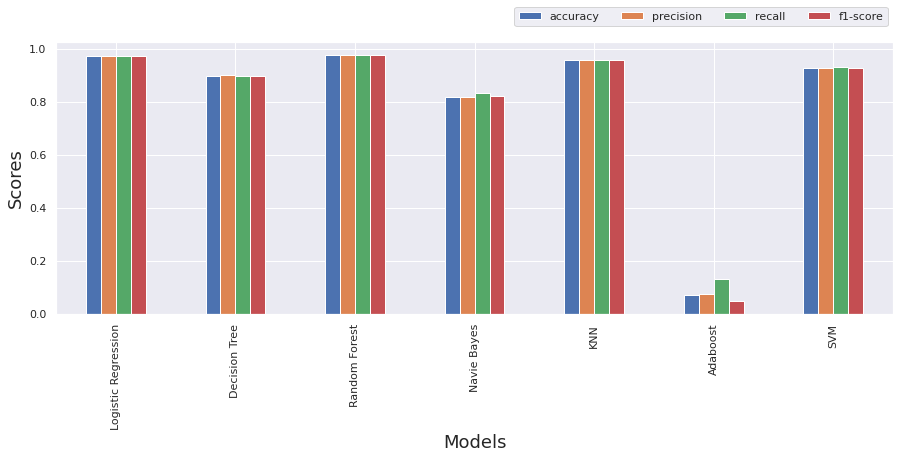

In [ ]:
plot_performance_metrics_graph(metrics_df)

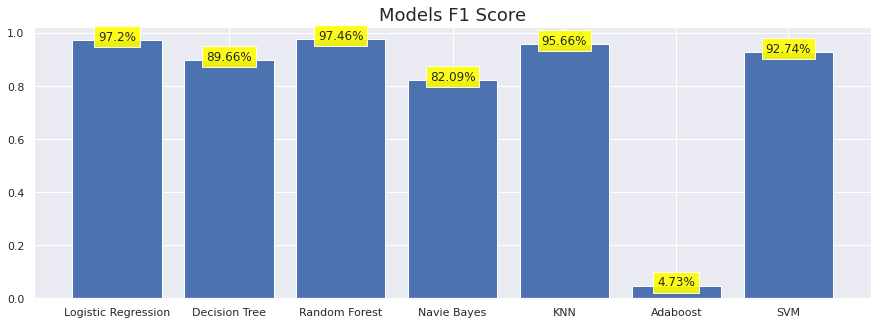

In [ ]:
models_acc = metrics_df.iloc[3].tolist()
models_names = metrics_df.columns.tolist()
plt.figure(figsize=(15,5))
plt.bar(models_names,models_acc)
plt.title("Models F1 Score", fontsize=18)

def addLabels(names,acc):
    for i in range(len(names)):
        plt.text(i,round(acc[i],4),f"{round(acc[i]*100,2)}%", ha = 'center', bbox=dict(facecolor='yellow', alpha=0.9))

addLabels(models_names,models_acc)
plt.show()

In [ ]:
model = rf

In [ ]:
cr = classification_report(model.predict(X_test), y_test)

In [ ]:
# Extract the classes from the report
class_names = cr.split('\n')[1:-5]
class_names = [int(name.split()[0]) for name in class_names[1:]]

# Print the classes
print(class_names)
print()

[1, 2, 3, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45]



In [ ]:
df_token = CATEGORY_I[['Unnamed: 1','Unnamed: 2']][1:].rename({'Unnamed: 1':'Meaning','Unnamed: 2':'Token'}, axis = 1)

In [ ]:
CLASSES_MEANING = df_token[df_token['Token'].isin(class_names)]['Meaning'].tolist()

In [ ]:
cr = classification_report(model.predict(X_test), y_test, target_names=CLASSES_MEANING)
print(cr)

                                                          precision    recall  f1-score   support

                                    MARKED UP COMMITMENT       0.98      0.94      0.96       273
                                               DEED COPY       0.97      0.95      0.96       242
                                            AFF OF TITLE       0.98      1.00      0.99       236
                                  ALTA BUYER’S STATEMENT       0.95      0.97      0.96       249
                                               SELLER CD       1.00      0.94      0.97       261
                                 ALTA SELLER’S STATEMENT       0.97      0.95      0.96       238
                                              BUYER’S CD       0.94      0.96      0.95       249
                                   LENDER’S INSTRUCTIONS       0.84      0.89      0.87       235
                                        Loan Application       1.00      0.99      1.00       243
                   

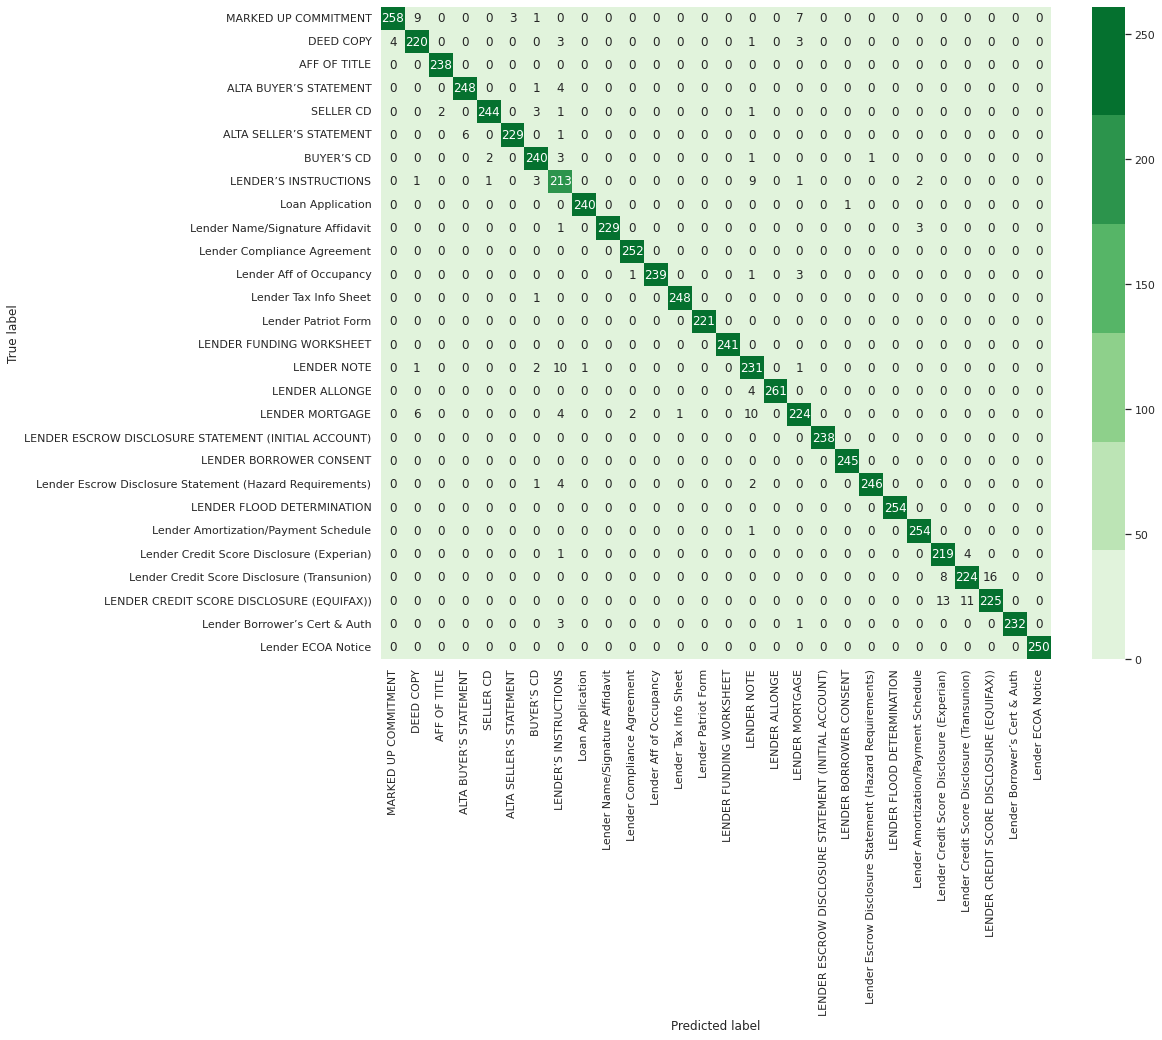

In [ ]:
from matplotlib.gridspec import tight_layout
cm = confusion_matrix(lr.predict(X_test), y_test)
# creating a colormap
colormap = sns.color_palette("Greens")
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt="", cmap=colormap, xticklabels=CLASSES_MEANING, yticklabels=CLASSES_MEANING)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.savefig("ConfusionMatrix.jpg", bbox_inches='tight')
plt.show()


In [ ]:
import pickle
pickle.dump(model, open('/content/drive/MyDrive/Annotation Folder/RF_CATEGORY_I_model_1_Mar.pkl', 'wb'))

In [ ]:
pickled_model = pickle.load(open('/content/drive/MyDrive/Annotation Folder/RF_CATEGORY_I_model_1_Mar.pkl', 'rb', pickle.HIGHEST_PROTOCOL))  # Load the model
f1_score(pickled_model.predict(X_test), y_test, average='macro')

0.9745909549440589